In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns

from neurasort.preprocessing import free_whisking_preprocessing_pipe

# 0.0 Load raw prediction data for the free whisking setting

In [2]:
# data_ohe_scaled_constant_free_filled = pd.read_csv("data_ohe_scaled_constant_free_filled.csv")
# data_ohe_scaled_constant_free_filled

raw_predictors_free_whisking = pd.read_csv("raw_predictors_free_whisking.csv")
raw_predictors_free_whisking

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,Cell_APThreshold_Slope,Cell_Depth,Cell_Layer,Cell_tdTomatoExpressing
0,EXC,3.25,-0.028422,0.563846,-0.038375,0.005196,0.000043,0.000518,10.0,229.0,L2/3,False
1,EXC,0.20,-0.033953,1.012500,-0.049049,0.004335,0.000053,0.000485,10.0,350.0,L2/3,False
2,EXC,0.05,-0.039291,3.350000,-0.050940,0.005286,0.000063,0.000519,10.0,350.0,L2/3,False
3,EXC,0.00,0.000000,0.000000,-0.047544,0.004778,0.000057,0.000557,10.0,350.0,L2/3,False
4,EXC,0.15,-0.033361,1.733333,-0.046490,0.002881,0.000031,0.000403,10.0,244.0,L2/3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
492,SST,6.60,-0.047992,0.564015,-0.056633,0.003752,0.000066,0.000438,20.0,196.0,L2/3,True
493,SST,6.80,-0.047427,0.578676,-0.056827,0.004175,0.000071,0.000514,20.0,196.0,L2/3,True
494,SST,7.50,-0.047400,0.589667,-0.056011,0.004038,0.000067,0.000460,20.0,196.0,L2/3,True
495,SST,5.50,-0.048279,0.580455,-0.056918,0.003525,0.000054,0.000430,20.0,196.0,L2/3,True


# 0.1 Create the free whisking preprocessing pipeline

In [3]:
preprocessing_pipe = free_whisking_preprocessing_pipe()

# 0.2 Calculate the class weights

In [4]:
class_weights = (1 - raw_predictors_free_whisking["cell_type"].value_counts() / raw_predictors_free_whisking["cell_type"].shape[0]).to_dict()
class_weights

{'SST': 0.6921529175050302,
 'EXC': 0.7062374245472838,
 'PV': 0.7565392354124748,
 'VIP': 0.8450704225352113}

# 0.3 Create list of models to test

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [46]:
models = [
    LogisticRegression(random_state=0, class_weight=class_weights),
    RandomForestClassifier(random_state=0, class_weight=class_weights), 
    GradientBoostingClassifier(random_state=0), 
    AdaBoostClassifier(random_state=0),
    DecisionTreeClassifier(random_state=0, class_weight=class_weights),
    SVC(random_state=0, class_weight=class_weights), 
    NuSVC(random_state=0, class_weight=class_weights), 
    LinearSVC(random_state=0, class_weight=class_weights),
    GaussianNB(),
]

# 1.0 Test all the models in the list

In [47]:
from sklearn.model_selection import StratifiedKFold
from neurasort.model_eval import fit_models_get_CV_score

In [48]:
cv_scores_df = fit_models_get_CV_score(
    models=models,
    X = raw_predictors_free_whisking.drop("cell_type", axis=1),
    y = raw_predictors_free_whisking["cell_type"],
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scorings=["f1_micro", "f1_macro", "f1_weighted", "accuracy"],
    preprocessing_pipe=preprocessing_pipe,
)
cv_scores_df

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value

,model,fold,f1_micro,f1_macro,f1_weighted,accuracy
0,LogisticRegression,0,0.83,0.825462,0.82774,0.83
1,LogisticRegression,1,0.93,0.923153,0.92869,0.93
2,LogisticRegression,2,0.838384,0.815969,0.835242,0.838384
3,LogisticRegression,3,0.909091,0.891032,0.908712,0.909091
4,LogisticRegression,4,0.919192,0.910952,0.917884,0.919192
5,RandomForestClassifier,0,0.93,0.927455,0.930223,0.93
6,RandomForestClassifier,1,0.98,0.979078,0.979912,0.98
7,RandomForestClassifier,2,0.959596,0.958807,0.959681,0.959596
8,RandomForestClassifier,3,0.939394,0.930348,0.939806,0.939394
9,RandomForestClassifier,4,0.939394,0.931856,0.938604,0.939394


# 1.1 Plot the results

In [49]:
import matplotlib.pyplot as plt

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_7507/200675230.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = ax.get_xticklabels() ,rotation = 45, ha="right")


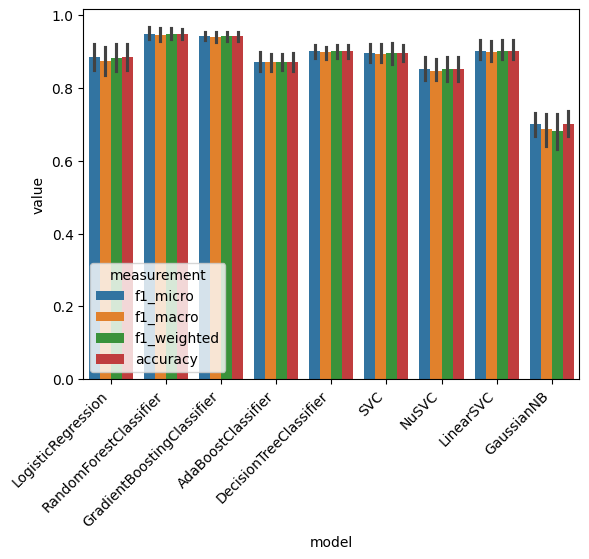

In [50]:
ax = sns.barplot(
    data=cv_scores_df.melt(id_vars=['model', 'fold'], var_name='measurement', value_name='value'),
    x="model",
    y="value",
    hue="measurement"
)
    
ax.set_xticklabels(labels = ax.get_xticklabels() ,rotation = 45, ha="right")
# for i in ax.containers:
#     ax.bar_label(
#         i,
#     )
plt.show()
# ax = sns.barplot(cv_scores_df, x="model", y="f1_weighted", hue="model", legend=False)
# ax.set_xticklabels(labels = ax.get_xticklabels() ,rotation = 45, ha="right")
# for i in ax.containers:
#     ax.bar_label(
#         i,
#     )
# plt.show()

# 1.2 Tune the 3 best models

## 1.2.0 GradientBoostingClassifier

In [51]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective

In [28]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", GradientBoostingClassifier(random_state=0))
)
clf_pipe

Pipeline(steps=[('OHE & scaling',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Cell_tdTomatoExpressing',
                                                   'Cell_Layer']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Cell_APThreshold_Slope',
                                                   'Cell_Depth', 'firing_rate',
                                                   'ap_duration', 'std_vm',
                                                   'fft_low', 'fft_high']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['ap_threshold', 'mean_vm'])],
                                   verbose_feature_names_out=False)),
                ('remove constants', VarianceThreshold()),
                ('impute cell depth', IterativeImputer(random_state=0)),
                ('clf', GradientBoostingClassifier(random_state=0))])

In [29]:
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__n_estimators": Integer(10, 500),
        # "estimator": Categorical(
        #     [None, RandomForestClassifier(random_state=0)]
        # ),
        "clf__learning_rate": Real(1e-3, 1, "log-uniform"),
    },
    n_iter=75,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
              estimator=Pipeline(steps=[('OHE & scaling',
                                         ColumnTransformer(transformers=[('onehotencoder',
                                                                          OneHotEncoder(drop='if_binary',
                                                                                        sparse_output=False),
                                                                          ['Cell_tdTomatoExpressing',
                                                                           'Cell_Layer']),
                                                                         ('minmaxscaler',
                                                                          MinMaxScaler(),
                                                                          ['Cell_APThreshold_Slope',
                                                                           'Cell_Depth',
                                                                           'firing_rate',
                                                                           'ap_durat...
                                         VarianceThreshold()),
                                        ('impute cell depth',
                                         IterativeImputer(random_state=0)),
                                        ('clf',
                                         GradientBoostingClassifier(random_state=0))]),
              n_iter=75, random_state=0, scoring='f1_weighted',
              search_spaces={'clf__learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'clf__n_estimators': Integer(low=10, high=500, prior='uniform', transform='normalize')})

array([[<Axes: xlabel='clf__learning_rate', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='clf__learning_rate', ylabel='clf__n_estimators'>,
        <Axes: xlabel='clf__n_estimators', ylabel='Partial dependence'>]],
      dtype=object)

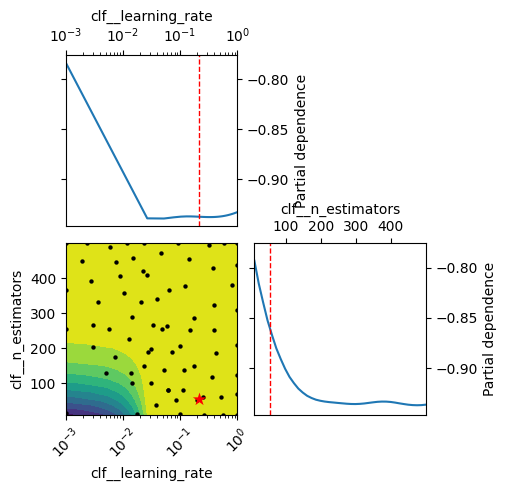

In [30]:
plot_objective(opt.optimizer_results_[0])

In [31]:
opt.best_score_, opt.best_params_

(0.9496626964080669,
 OrderedDict([('clf__learning_rate', 0.21421828028126513),
              ('clf__n_estimators', 54)]))

## 1.2.1 SVC

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/skopt/optimize

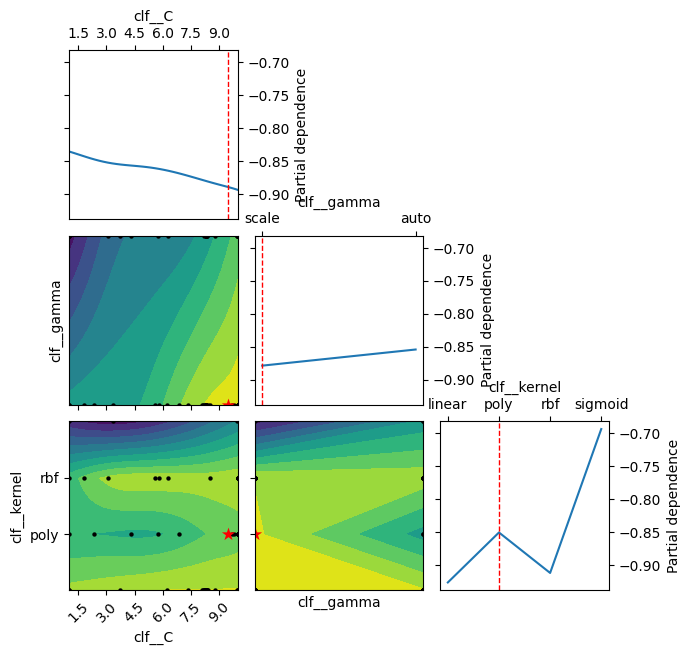

(0.9394401859233037,
 OrderedDict([('clf__C', 9.48303148896607),
              ('clf__gamma', 'scale'),
              ('clf__kernel', 'poly')]))

In [36]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", SVC(random_state=0))
)
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__gamma": Categorical(['scale', 'auto']),
        "clf__kernel": Categorical(
            ['linear', 'poly', 'rbf', 'sigmoid']
        ),
        "clf__C": Real(1, 10, "uniform"),
    },
    n_iter=60,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)
plot_objective(opt.optimizer_results_[0])
plt.show()
opt.best_score_, opt.best_params_

## 1.2.2 RandomForestClassifier

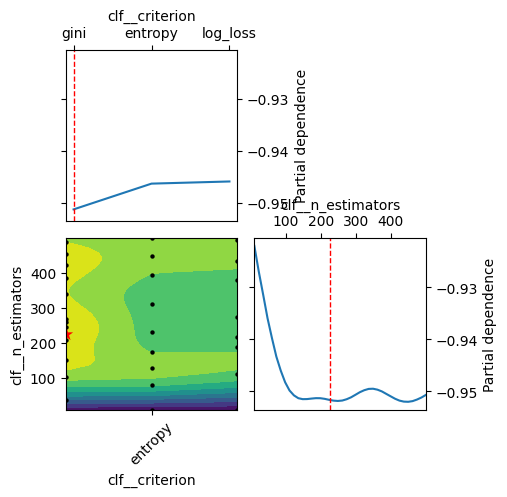

(0.9576891077947419,
 OrderedDict([('clf__criterion', 'gini'), ('clf__n_estimators', 226)]))

In [52]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", RandomForestClassifier(random_state=0, class_weight=class_weights))
)
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__n_estimators": Integer(10, 500),
        "clf__criterion": Categorical(['gini', 'entropy', 'log_loss']),
    },
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)
plot_objective(opt.optimizer_results_[0])
plt.show()
opt.best_score_, opt.best_params_

# 2.0 Test a Neural Network

In [8]:
from neurasort.sktorch import FeedForwardExample
import torch.nn as nn
import torch

In [9]:
nn_model = FeedForwardExample(
    num_epochs=100,
    optimizer_class=torch.optim.AdamW,
    loss_function=nn.CrossEntropyLoss(),
    batch_size=4,
    lr=1e-1,
    save_train_loss=False,
    num_classes=4,
)

In [10]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", nn_model)
)
clf_pipe

Pipeline(steps=[('OHE & scaling',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Cell_tdTomatoExpressing',
                                                   'Cell_Layer']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Cell_APThreshold_Slope',
                                                   'Cell_Depth', 'firing_rate',
                                                   'ap_duration', 'std_vm',
                                                   'fft_low', 'fft_high']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['ap_thresh...
                ('remove constants', VarianceThreshold()),
                ('impute cell depth', IterativeImputer(random_state=0)),
                ('clf',
                 FeedForwardExample(
  (loss_function): CrossEntropyLoss()
  (layers): Sequential(
    (0): LazyLinear(in_features=0, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
    (5): Softmax(dim=None)
  )
))])

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
label_encoder = LabelEncoder()
clf_pipe.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = pd.Series(label_encoder.fit_transform(raw_predictors_free_whisking["cell_type"]))
)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 100/100 [00:12<00:00,  7.91it/s]


Pipeline(steps=[('OHE & scaling',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Cell_tdTomatoExpressing',
                                                   'Cell_Layer']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Cell_APThreshold_Slope',
                                                   'Cell_Depth', 'firing_rate',
                                                   'ap_duration', 'std_vm',
                                                   'fft_low', 'fft_high']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['ap_thresh...
                ('remove constants', VarianceThreshold()),
                ('impute cell depth', IterativeImputer(random_state=0)),
                ('clf',
                 FeedForwardExample(
  (loss_function): CrossEntropyLoss()
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
    (5): Softmax(dim=None)
  )
))])

In [13]:
clf_pipe.predict(raw_predictors_free_whisking.drop("cell_type", axis=1))

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
    